In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#Setup training Data
train_data = datasets.MNIST(
    root="data", # where to download data to ?
    train=True,  # do we want the training dataset?
    download=True, # do we want to download it?
    transform=torchvision.transforms.ToTensor(),  # how we want to transform the data?
    target_transform=None  # how do we want to transform the lables?
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [ ]:
#Make Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
image,label = train_data[0]
image.shape,label

(torch.Size([1, 28, 28]), 5)

In [ ]:
len(train_data.targets)

60000

In [ ]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape: torch.Size([1, 28, 28])


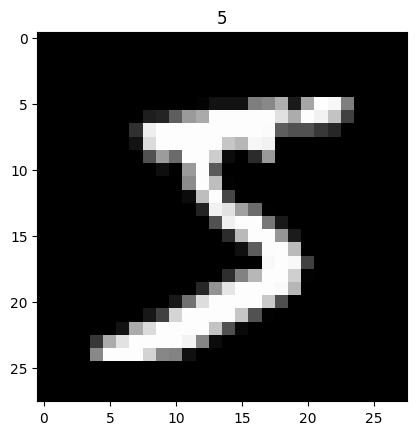

In [ ]:
import matplotlib.pyplot as plt

print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
plt.show()

In [ ]:
from torch.utils.data import random_split

# Define the lengths for training and validation
train_size = int(0.8 * len(train_data))  # 80% for training
val_size = len(train_data) - train_size   # 20% for validation

# Randomly split dataset
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [ ]:
#Let's create a DataLoader's for our training and test sets

from torch.utils.data import DataLoader

# Setup batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
                              batch_size=BATCH_SIZE,# how many samples per batch?
                              shuffle=True)# shuffle data every epoch?
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

#Let's checkout what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ec029ba59f0>, <torch.utils.data.dataloader.DataLoader object at 0x7ec029ba7820>)
Length of train dataloader: 1500 batches of 32
Length of val dataloader: 375 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
#Building a multi-class classification model
class ClassifyDigit(nn.Module):
  def __init__(self,input_features: int,output_features: int):
    """Initializes all required hyperparameters for a multi-class classification model.
    Args:
         input_features (int): Number of input features to the model.
         out_features (int)  : Number of output features of the model
                               (how many classes there are).
         hidden_units (int)  : Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features,out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128,out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60,out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Creating an Instance of our Model.
model= ClassifyDigit(input_features=784,
                    output_features=len(train_data.classes)).to(device)
model


ClassifyDigit(
  (linear_layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=60, bias=True)
    (4): ReLU()
    (5): Linear(in_features=60, out_features=30, bias=True)
    (6): ReLU()
    (7): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1,1,28,28]).to(device)
y_test=model(dummy_x)   #in output we get 10 logits(one logit per class)
y_test

tensor([[ 0.2025, -0.0647, -0.0994, -0.0440, -0.1758,  0.1492,  0.0521, -0.1023,
          0.1537, -0.0129]], grad_fn=<AddmmBackward0>)

In [ ]:
y_pred_probs = torch.softmax(y_test,dim=1)
print(f"{y_test}\n{y_pred_probs}")
print(torch.sum(y_pred_probs))
print(torch.argmax(y_pred_probs))

tensor([[ 0.2025, -0.0647, -0.0994, -0.0440, -0.1758,  0.1492,  0.0521, -0.1023,
          0.1537, -0.0129]], grad_fn=<AddmmBackward0>)
tensor([[0.1208, 0.0925, 0.0893, 0.0944, 0.0828, 0.1146, 0.1040, 0.0891, 0.1151,
         0.0974]], grad_fn=<SoftmaxBackward0>)
tensor(1., grad_fn=<SumBackward0>)
tensor(0)


In [ ]:
#Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.01)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
for i,(x,y) in enumerate(train_dataloader):
  print(f"{i} -> {y}")
  break

0 -> tensor([0, 1, 5, 6, 3, 7, 4, 2, 7, 9, 1, 6, 9, 7, 7, 5, 0, 5, 9, 8, 3, 7, 3, 9,
        6, 6, 3, 1, 9, 3, 1, 2])


In [ ]:
len(train_dataloader),len(val_dataloader)

(1500, 375)

In [ ]:
import numpy as np
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start = timer()

# Set the number of epochs (we'll keep this small for faster traing time)
epochs = 10
train_loss=0
val_loss=0
# Create training and test loop
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")

  ### Training
  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):   # Train data loader is one which has 60000/32 batches ,, (X,y):(Image,Label) ,  enumerate for keeping the track of number of batches we've been through.
    model.train()
    # 1. Forward Pass
    y_train_logits = model(X.to(device))
    y_pred = torch.softmax(y_train_logits,dim=1).argmax(dim=1)
    # 2. Calculate the loss (per batch)
    loss = loss_fn(y_train_logits, y.to(device))
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    #Optimizeter will update the parameter per batch rathen than per epoch.

    #Print out whats happening
    if batch%100 ==0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples") #len(X)->32

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)  #Average loss per epochs
  print(train_loss)

  ### Testing
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in val_dataloader:
      #1. Forward pass
      test_logits = model(X_test.to(device))
      test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
      #2. Calculate the loss (accumualatively)
      val_loss += loss_fn(test_logits,y_test.to(device))
    # Calculate the Test_Loss average per batch
    val_loss /= len(val_dataloader)
  # Print out what's happening

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {val_loss:.5f}\n")

#Calulate the training time omn "device"
train_time_end = timer()
total_train_time_model = print_train_time(start=train_time_start , end=train_time_end, device=str(next(model.parameters()).device))

Epoch: 0
---------
Looked at 0/48000 samples
Looked at 3200/48000 samples
Looked at 6400/48000 samples
Looked at 9600/48000 samples
Looked at 12800/48000 samples
Looked at 16000/48000 samples
Looked at 19200/48000 samples
Looked at 22400/48000 samples
Looked at 25600/48000 samples
Looked at 28800/48000 samples
Looked at 32000/48000 samples
Looked at 35200/48000 samples
Looked at 38400/48000 samples
Looked at 41600/48000 samples
Looked at 44800/48000 samples
tensor(0.3129, grad_fn=<DivBackward0>)

Train loss: 0.31287 | Test loss: 0.23745

Epoch: 1
---------
Looked at 0/48000 samples
Looked at 3200/48000 samples
Looked at 6400/48000 samples
Looked at 9600/48000 samples
Looked at 12800/48000 samples
Looked at 16000/48000 samples
Looked at 19200/48000 samples
Looked at 22400/48000 samples
Looked at 25600/48000 samples
Looked at 28800/48000 samples
Looked at 32000/48000 samples
Looked at 35200/48000 samples
Looked at 38400/48000 samples
Looked at 41600/48000 samples
Looked at 44800/48000 sa

In [ ]:
!pip install torchmetrics

For Batch 0 
the predicted outputs are 
tensor([7, 2, 1, 0, 4, 1, 4, 9, 8, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
 and the original outputs are 
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
For Batch 100 
the predicted outputs are 
tensor([9, 2, 7, 1, 8, 8, 3, 2, 7, 6, 0, 1, 2, 7, 1, 0, 8, 3, 6, 0, 5, 3, 6, 2,
        8, 7, 0, 1, 4, 2, 1, 1])
 and the original outputs are 
tensor([9, 2, 7, 1, 8, 8, 8, 2, 7, 6, 0, 1, 2, 7, 1, 0, 8, 3, 6, 0, 5, 3, 6, 2,
        8, 7, 0, 1, 4, 2, 1, 1])
For Batch 200 
the predicted outputs are 
tensor([8, 9, 6, 8, 8, 5, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4, 2, 1, 9, 2, 9, 2,
        0, 6, 2, 4, 0, 0, 1, 2])
 and the original outputs are 
tensor([0, 9, 6, 8, 8, 5, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4, 2, 1, 9, 3, 9, 2,
        0, 6, 0, 4, 0, 0, 1, 2])
For Batch 300 
the predicted outputs are 
tensor([5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7

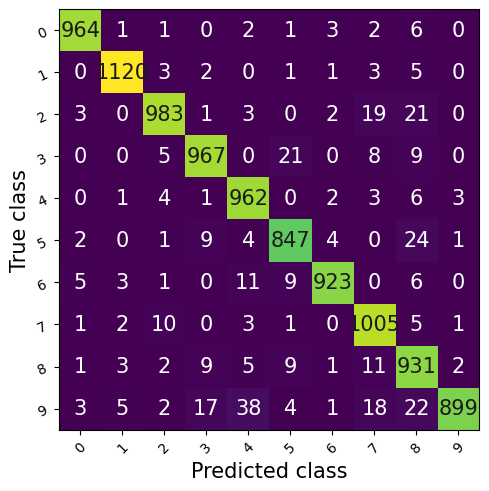

In [ ]:
# Making Predictions
model.eval()
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassConfusionMatrix

accuracy_fn = Accuracy("multiclass",num_classes=10).to(device)
metric = MulticlassConfusionMatrix(num_classes=10).to(device)

overall_acc=0
y_pred=[]
y_true=[]

with torch.inference_mode():
  for batch,(x,y) in enumerate(test_dataloader):
    test_logits = model(x.to(device))
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    y_pred.append(test_pred)
    y_true.append(y)
    acc=accuracy_fn(test_pred,y)
    overall_acc+=acc
    if batch%100==0:
      print(f"For Batch {batch} \nthe predicted outputs are \n{test_pred}\n and the original outputs are \n{y}")
  print(f"\n \nThe overall Accuracy is {(overall_acc/len(test_dataloader))*100}%")
  y_pred = torch.cat(y_pred)
  y_true = torch.cat(y_true)
  metric(y_pred,y_true)
  metric.plot()